In [1]:
import sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import os
sys.path.append(os.path.abspath("../../src/"))  # now src is on sys.pathimport HP_Operation as operation
import HP_Operation as operation
import OpenMeteo_API as openMeteo
import RC_Model as rc_model

###################### ======================== Case Study 1 ======================= ###########################

file_path = os.path.join("data/dataset2.xlsx")
cs1 = pd.read_excel(file_path)

cs1["INDOOR_TEMP"] = cs1[["RTD31", "RTD34", "RTD37", "RTD40", "RTD41"]].mean(axis=1)
# Rename columns
rename_mapping = {
        'Tout': 'OUTDOOR_TEMP',
        'PhRad_actual_power': 'PHI_H',
        'SolGlob': 'PYRANOMETER'
    }
cs1 = cs1.rename(columns=rename_mapping)
# Convert 't' to datetime and set as index

cs1['Time'] = pd.to_datetime(cs1['Time'])
cs1 = cs1.set_index('Time')
cs1_surface_area = 100  # m² 
cs1 = cs1.iloc[0:960]

train_cs1, val_cs1, test_cs1 = rc_model.split_dataset(cs1, testing_days=3, val_split=0.3)

###################### ======================== Case Study 2 - Cyprus House ======================= ###########################

cs2 = pd.read_excel('data/TRNSYS_houses.xlsx', usecols="A:H")
rename_mapping = {
        'Tamb': 'OUTDOOR_TEMP',
        'COOL [kW]': 'PHI_H',
        'Qsol [W]': 'PYRANOMETER'
    }
cs2["INDOOR_TEMP"] = 25
cs2 = cs2.rename(columns=rename_mapping)
cs2['PHI_H']= cs2['PHI_H']*1000
cs2.index = pd.date_range(start='2023-01-01 00:00:00', periods=len(cs2), freq='h')
cs2 = cs2[((cs2.index.month == 6) & (cs2.index.day >= 5)) & ((cs2.index.month == 6) & (cs2.index.day <= 12))]
train_cs2, val_cs2, test_cs2 = rc_model.split_dataset(cs2, testing_days=3, val_split=0.3)

%load_ext autoreload
%autoreload 2

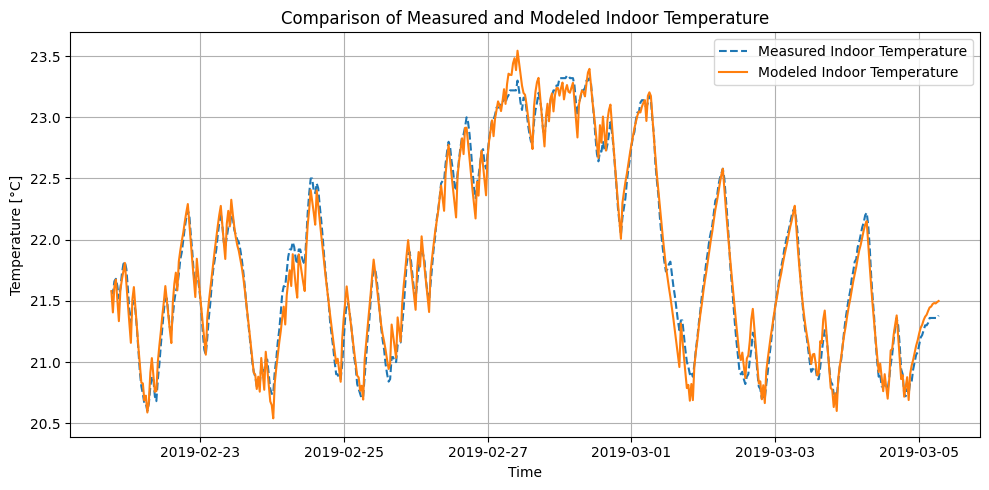

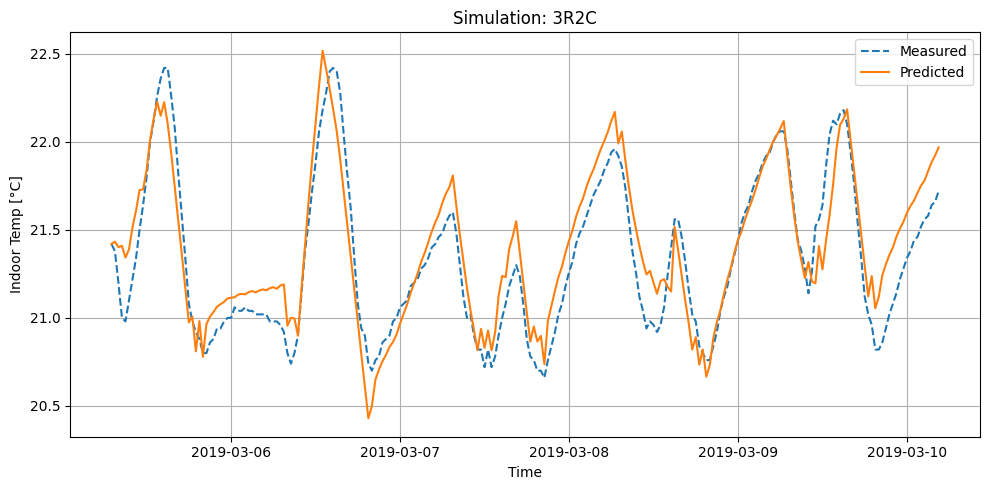


=== Best result ===
Best Trial Validation #: 0
Best Trial Training #: 0
Best RMSE Validation: 0.1864
RMSE Training of Best Validation : 0.0109
Best RMSE Training: 0.0109
Best initialization Validation: {'R_in_e': 0.7741327878416825, 'R_e_a': 0.585616488135105, 'R_in_a': 0.5425056325732568, 'C_in': 365010146.32316613, 'C_e': 347189232.9136834, 'Ain': 0.2625404823371945, 'Ae': 18.779215617465102, 'fh': 0.6034755850388116}
Best initialization Training: {'R_in_e': 0.7741327878416825, 'R_e_a': 0.585616488135105, 'R_in_a': 0.5425056325732568, 'C_in': 365010146.32316613, 'C_e': 347189232.9136834, 'Ain': 0.2625404823371945, 'Ae': 18.779215617465102, 'fh': 0.6034755850388116}
Best parameters Validation: {'R_in_e': 0.020282263774486123, 'R_e_a': 0.015201422663125061, 'R_in_a': 0.1758421982311592, 'C_in': 1268922.8571577696, 'C_e': 23256596.75874604, 'Ain': 0.25994627628363826, 'Ae': 1.9094832638138852, 'fh': 0.06876587093338395, 'Objective': 0.01086347574834647, 'Solve_time': 0.7388842105865479

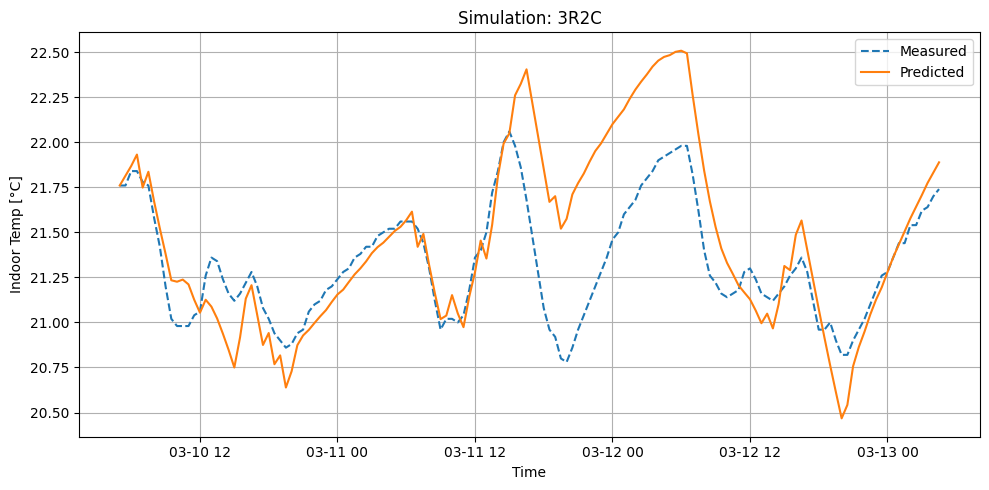

In [3]:
###################### ======================== Case Study 1 ======================= ###########################
bounds_cs1 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}

model_3r2c_cs1, parameters_3r2c_cs1, best_initialization_3r2c_cs1, validation_pred_3r2c_cs1, initialize_testing_3r2c_cs1, all_trials_3r2c_cs1 = rc_model.train_greybox_t_model_with_validation_process(
    train_df=train_cs1, val_df=val_cs1, model_type="3R2C", bounds=bounds_cs1, 
    num_trials=1, deltaT=1800, show_plot=True, log=False)

initialize_testing_3r2c_cs1['Tin'] = test_cs1['INDOOR_TEMP'].iloc[0]

# --- Run Simulation for Testing ---
testing_performance_3r2c_cs1, testing_df_3r2c_cs1 = rc_model.simulate_and_evaluate(
        val_df=test_cs1, param_dict=parameters_3r2c_cs1, model_type="3R2C",
        initializations=initialize_testing_3r2c_cs1, show_plot=True
    )

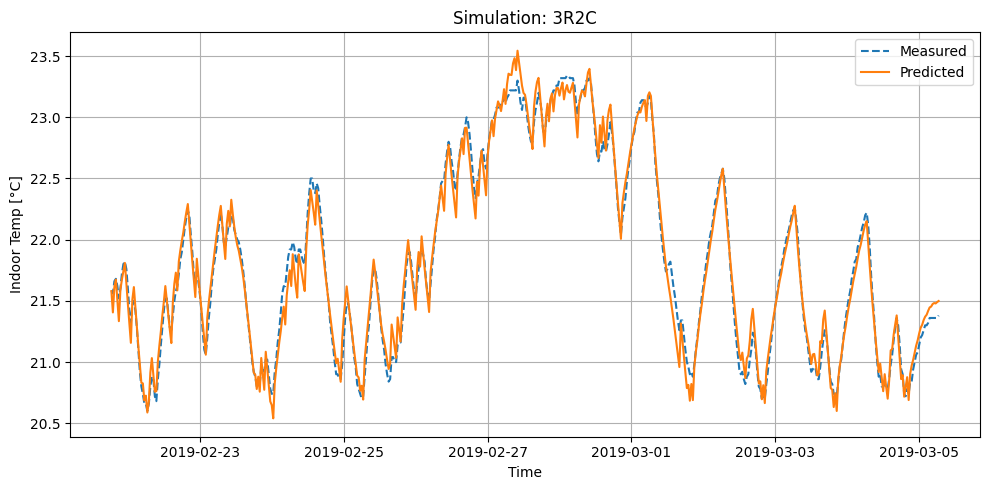

In [4]:
Initialization = {'Te':model_3r2c_cs1.T_e[0](), 'Tin':model_3r2c_cs1.T_in[0]()}

# --- Run Simulation for Testing ---
testing_performance_3r2c_cs1, testing_df_3r2c_cs1 = rc_model.simulate_and_evaluate(
        val_df=train_cs1, param_dict=parameters_3r2c_cs1, model_type="3R2C",
        initializations=Initialization, show_plot=True
    )

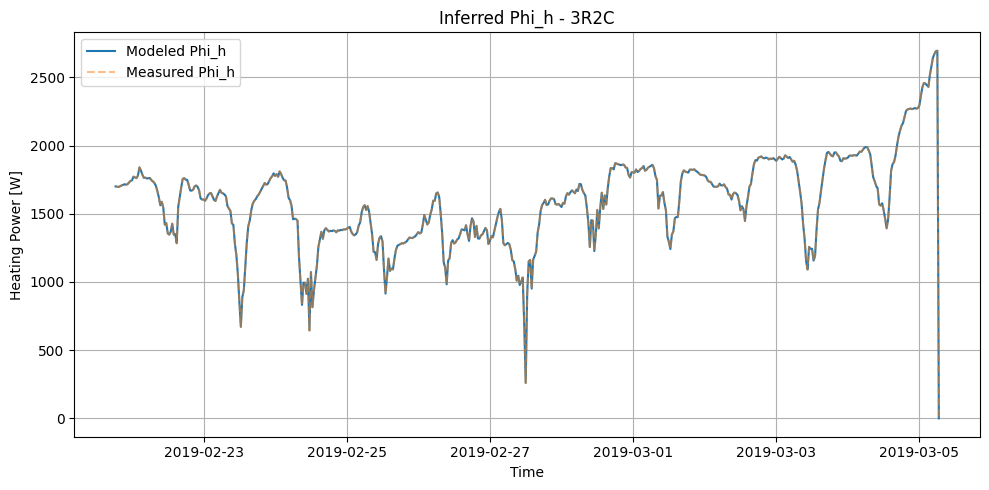

In [13]:
# train_cs1['INDOOR_TEMP']=testing_df_3r2c_cs1['T_in_estimate']
train_cs1['INDOOR_TEMP'] = 25
Initialization = {'Te':25.5, 'Tin':25}
power = rc_model.simulate_Qh(df=train_cs1, param_dict=parameters_3r2c_cs1,initializations=Initialization,model_type="3R2C",deltaT=1800,show_plot=True)
power[-1]=power[-2]
train_cs1['PHI_H']=power

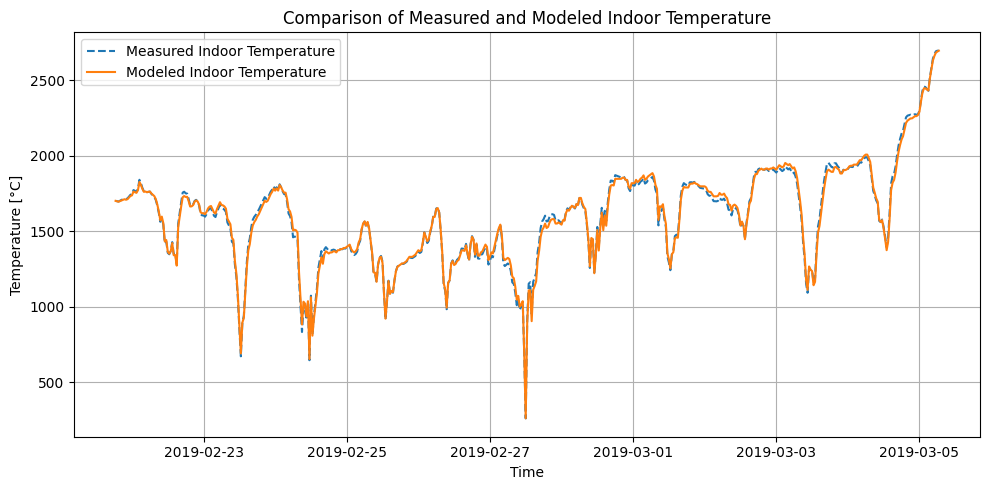

[Trial 1] RMSE = 22.1054, Init: {'R_in_e': 0.21018989515852526, 'R_e_a': 0.04289163241337116, 'R_in_a': 0.2620854658525248, 'C_in': 42339446.10977495, 'C_e': 24579984.312001366, 'Ain': 44.804410280477846, 'Ae': 23.976313744188428, 'fh': 0.22439675270049342}
 parameters: {'R_in_e': 0.19611155941873717, 'R_e_a': 1.0000000099087083, 'R_in_a': 0.013619893699713382, 'C_in': 25004787.1673839, 'C_e': 353210.78413987474, 'Ain': 3.7615127474053742, 'Ae': 9.999000348287189e-05, 'fh': 1, 'Objective': 488.6495576213726, 'Solve_time': 0.6631531715393066}

=== Best result ===
Best Trial #: 1
Best RMSE: 22.1054
Best initialization: {'R_in_e': 0.21018989515852526, 'R_e_a': 0.04289163241337116, 'R_in_a': 0.2620854658525248, 'C_in': 42339446.10977495, 'C_e': 24579984.312001366, 'Ain': 44.804410280477846, 'Ae': 23.976313744188428, 'fh': 0.22439675270049342}
Best parameters: {'R_in_e': 0.19611155941873717, 'R_e_a': 1.0000000099087083, 'R_in_a': 0.013619893699713382, 'C_in': 25004787.1673839, 'C_e': 353210

In [16]:
# --- Bounds ---
bounds_cs1 = {
    "R_in_e": (0.01, 1),
    "R_e_a": (0.01, 1),
    "R_in_a": (0.01, 1),
    "C_in": (1e2, 5e7),
    "C_e": (1e2, 5e7),
    "Ain": (0.0001, 0.3 * 150),
    "Ae": (0.0001, 0.3 * 150),
    "fh": (0,1)
}


model_3r2c_cs1, parameters_3r2c_cs1, best_initialization_3r2c_cs1, all_trials_3r2c_cs1 = rc_model.train_greybox_q_model(
    train_df=train_cs1, model_type="3R2C", bounds=bounds_cs1, 
    num_trials=1, deltaT=1800, show_plot=True, log=True)

# ###################### ======================== Case Study 1 ======================= ###########################

# model_3r2c_cs1, parameters_3r2c_cs1, best_initialization_3r2c_cs1, validation_pred_3r2c_cs1, initialize_testing_3r2c_cs1, all_trials_3r2c_cs1 = train_greybox_model_with_validation_process(
#     train_df=train_cs1, val_df=val_cs1, model_type="3R2C", bounds=bounds_cs1, 
#     num_trials=30, deltaT=1800, show_plot=False, log=False)

# initialize_testing_3r2c_cs1['Tin'] = test_cs1['INDOOR_TEMP'].iloc[0]

# # --- Run Simulation for Testing ---
# testing_performance_3r2c_cs1, testing_df_3r2c_cs1 = simulate_and_evaluate(
#         val_df=test_cs1, param_dict=parameters_3r2c_cs1, model_type="3R2C",
#         initializations=initialize_testing_3r2c_cs1, show_plot=True
#     )
